In [ ]:
import pandas as pd

df = pd.read_csv('passenger_volume (2).csv')
print(df.head())
print(df.info())
print(df.describe())

         Date TransportType  Station/StopID  Location  DayOfWeek IsHoliday  \
0  2022-01-01         Train              56     Rural   Saturday        No   
1  2022-01-02           Bus               1     Urban     Sunday        No   
2  2022-01-03           Bus              51  Suburban     Monday        No   
3  2022-01-04           Bus             100  Suburban    Tuesday       Yes   
4  2022-01-05           Bus              12     Urban  Wednesday        No   

  WeatherCondition  Temperature SpecialEvents  PreviousDayPassengerVolume  \
0            Clear         12.7            No                        2845   
1            Snowy         31.1           Yes                        1883   
2            Clear          9.8            No                        2777   
3            Snowy         12.5           Yes                        4355   
4            Snowy         24.1            No                        3096   

   PassengerVolume  
0              670  
1             4166  
2    

In [ ]:
# Separate numeric and non-numeric columns
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
non_numeric_cols = df.select_dtypes(exclude=['float64', 'int64']).columns

# Fill missing values for numeric columns with mean
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].mean())

# Fill missing values for 'WeatherCondition' (categorical) with mode
df['WeatherCondition'].fillna(df['WeatherCondition'].mode()[0], inplace=True)

# For other non-numeric columns, decide on a strategy (e.g., mode, forward fill, backward fill)
df['TransportType'].fillna(df['TransportType'].mode()[0], inplace=True)
df['Date'].fillna(method='ffill', inplace=True)  # Example of forward filling dates

# Verify if there are any remaining missing values
print(df.isnull().sum())

Date                          0
TransportType                 0
Station/StopID                0
Location                      0
DayOfWeek                     0
IsHoliday                     0
WeatherCondition              0
Temperature                   0
SpecialEvents                 0
PreviousDayPassengerVolume    0
PassengerVolume               0
dtype: int64


<ipython-input-32-0c71ada6d4d3>:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['WeatherCondition'].fillna(df['WeatherCondition'].mode()[0], inplace=True)
<ipython-input-32-0c71ada6d4d3>:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(v

In [ ]:
# One-hot encoding for categorical columns
df = pd.get_dummies(df, columns=['WeatherCondition', 'Location', 'TransportType'], drop_first=True)

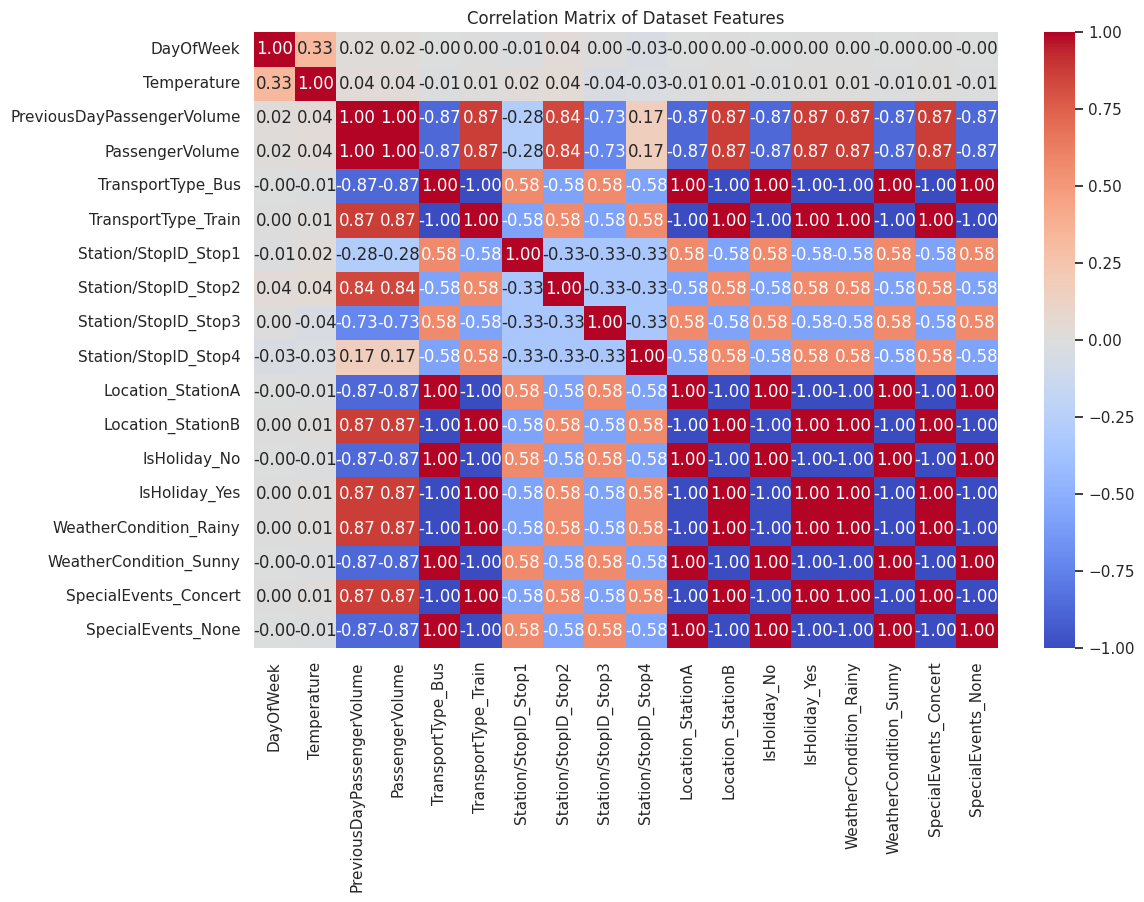

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming your dataset is stored in a DataFrame `df`
# Example dataset creation (replace with your actual data)
df = pd.DataFrame({
    'Date': pd.date_range(start='1/1/2023', periods=100),
    'TransportType': ['Bus', 'Train'] * 50,
    'Station/StopID': ['Stop1', 'Stop2', 'Stop3', 'Stop4'] * 25,
    'Location': ['StationA', 'StationB'] * 50,
    'DayOfWeek': [1, 2, 3, 4, 5, 6, 7] * 14 + [1, 2],
    'IsHoliday': ['No', 'Yes'] * 50,
    'WeatherCondition': ['Sunny', 'Rainy'] * 50,
    'Temperature': [25, 30, 22, 18, 26, 28, 32] * 14 + [25, 30],
    'SpecialEvents': ['None', 'Concert'] * 50,
    'PreviousDayPassengerVolume': [1000, 1500, 800, 1200] * 25,
    'PassengerVolume': [1050, 1550, 850, 1250] * 25
})

# Convert categorical variables to numerical using one-hot encoding
df_encoded = pd.get_dummies(df.drop(columns=['Date']))

# Calculate the correlation matrix
correlation_matrix = df_encoded.corr()

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation Matrix of Dataset Features")
plt.show()

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Mean Absolute Error: 1209.5416962890624
Mean Squared Error: 1978449.0535275068
R-squared: 0.0005866885185241699


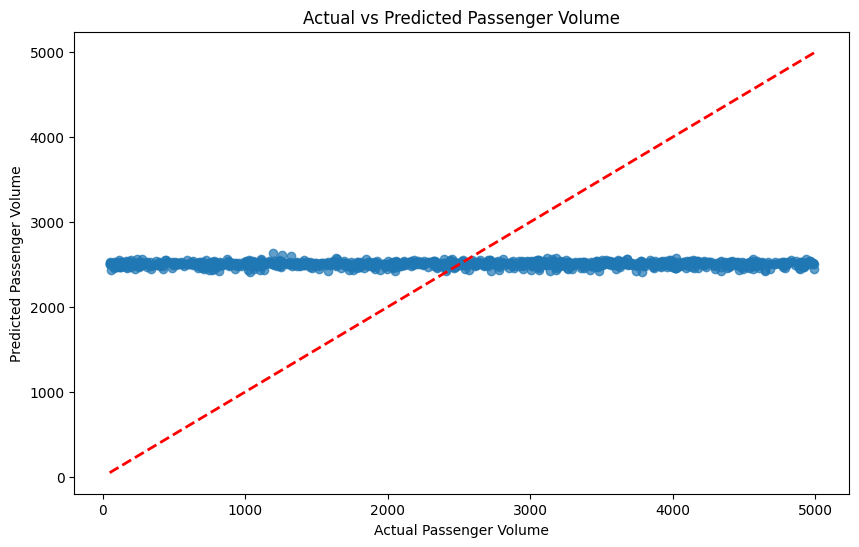

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Load the dataset
data = pd.read_csv('passenger_volume (2).csv')

# Data exploration
data.ffill(inplace=True)  # Handle missing values

# Feature engineering
data['Date'] = pd.to_datetime(data['Date'])
data['Year'] = data['Date'].dt.year
data['Month'] = data['Date'].dt.month
data['Day'] = data['Date'].dt.day
data['DayOfWeek'] = data['Date'].dt.dayofweek
data['IsWeekend'] = data['DayOfWeek'].apply(lambda x: 1 if x >= 5 else 0)

# Drop the original date column
data.drop(['Date'], axis=1, inplace=True)

# Split the dataset into features and target variable
X = data.drop('PassengerVolume', axis=1)
y = data['PassengerVolume']

# Split the dataset into training and testing sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocessing steps
categorical_cols = ['TransportType', 'Location', 'IsHoliday', 'WeatherCondition', 'SpecialEvents']
numerical_cols = ['Temperature', 'PreviousDayPassengerVolume', 'Month', 'IsWeekend']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(), categorical_cols)
    ])

# Create a pipeline with preprocessing and model
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor(objective='reg:squarederror'))
])

# Define hyperparameters for random search
param_distributions = {
    'regressor__n_estimators': [50, 100, 200],
    'regressor__max_depth': [3, 5, 7, 10],
    'regressor__learning_rate': [0.01, 0.1, 0.2],
    'regressor__subsample': [0.8, 1.0]
}

# Set up random search
random_search = RandomizedSearchCV(pipeline, param_distributions, n_iter=10, cv=3, n_jobs=-1, scoring='r2', verbose=2, random_state=42)

# Fit the model
random_search.fit(X_train, y_train)

# Best model from random search
best_model = random_search.best_estimator_

# Predictions
y_pred = best_model.predict(X_test)

# Evaluate model performance
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Display evaluation metrics
print(f'Mean Absolute Error: {mae}')
print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', lw=2)
plt.xlabel('Actual Passenger Volume')
plt.ylabel('Predicted Passenger Volume')
plt.title('Actual vs Predicted Passenger Volume')
plt.show()


/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


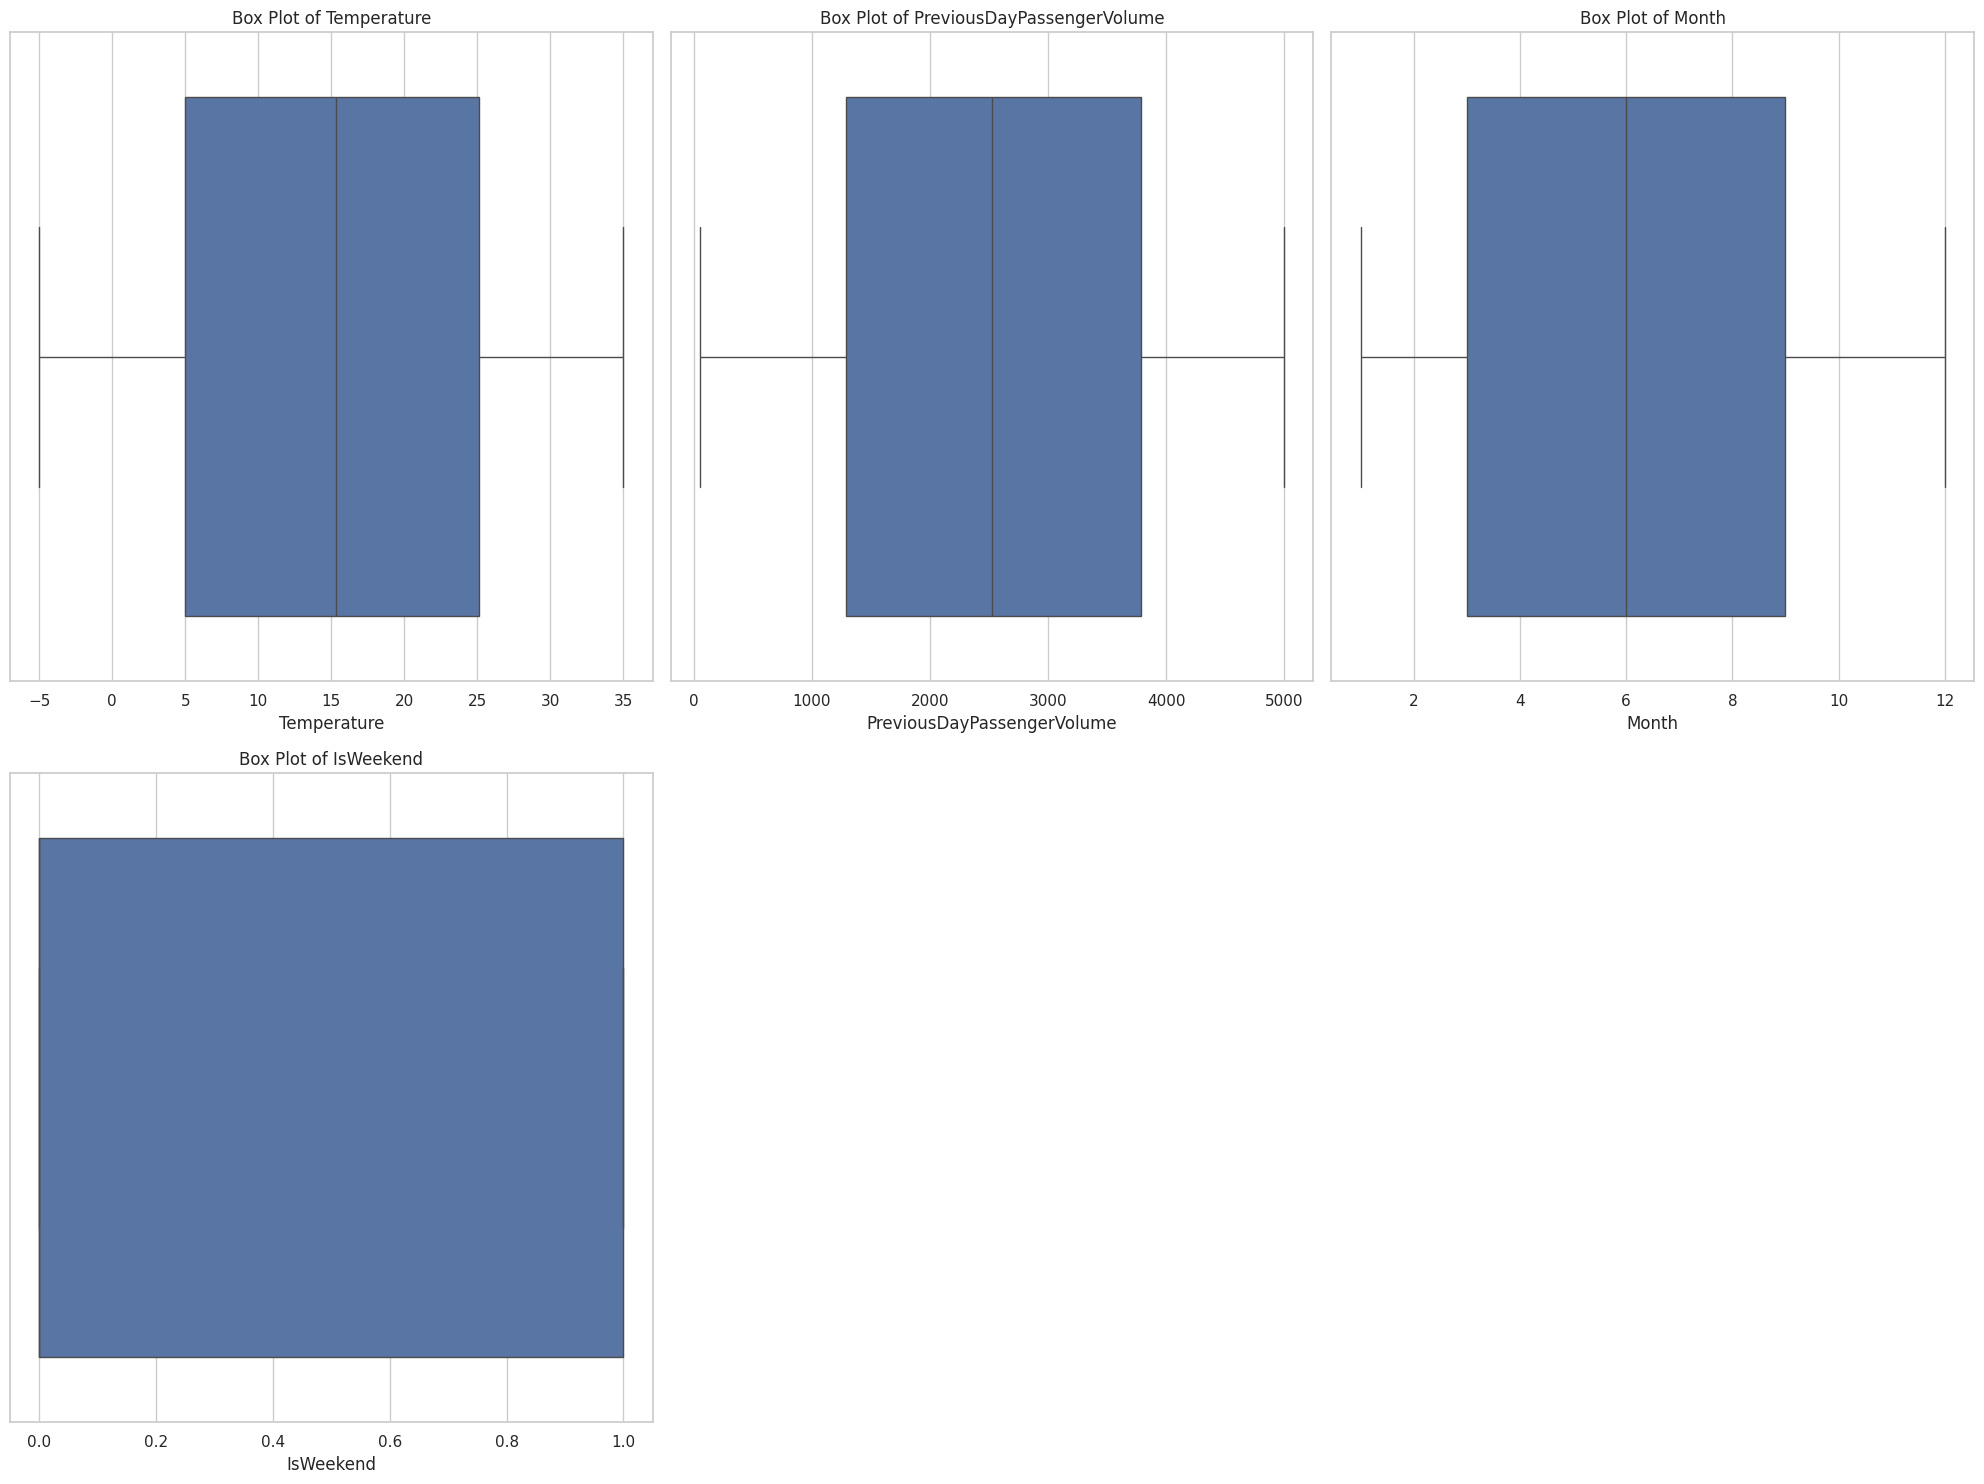

In [ ]:
# Import necessary libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the dataset
data = pd.read_csv('passenger_volume (2).csv')

# Data preprocessing (assuming you've already done this part)
data.ffill(inplace=True)  # Handle missing values

# Feature engineering (assuming this has been done as well)
data['Date'] = pd.to_datetime(data['Date'])
data['Year'] = data['Date'].dt.year
data['Month'] = data['Date'].dt.month
data['Day'] = data['Date'].dt.day
data['DayOfWeek'] = data['Date'].dt.dayofweek
data['IsWeekend'] = data['DayOfWeek'].apply(lambda x: 1 if x >= 5 else 0)

# Drop original Date column
data.drop(['Date'], axis=1, inplace=True)

# Specify the numerical columns
numerical_cols = ['Temperature', 'PreviousDayPassengerVolume', 'Month', 'IsWeekend']

# Create box plots for numerical columns
plt.figure(figsize=(20, 15))
sns.set(style="whitegrid")

# Iterate through each numerical column to create box plots
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(len(numerical_cols) // 3 + 1, 3, i)
    sns.boxplot(x=data[col])  # Pass each column to boxplot
    plt.title(f'Box Plot of {col}')
    plt.xlabel(col)

plt.tight_layout()
plt.show()


<ipython-input-5-555917df5ef3>:33: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['Lag_Passenger_Volume_7'].fillna(data['PreviousDayPassengerVolume'].mean(), inplace=True)


Fitting 3 folds for each of 10 candidates, totalling 30 fits
Mean Absolute Error: 1210.4718518066406
Mean Squared Error: 1978525.9657037372
R-squared: 0.000547945499420166


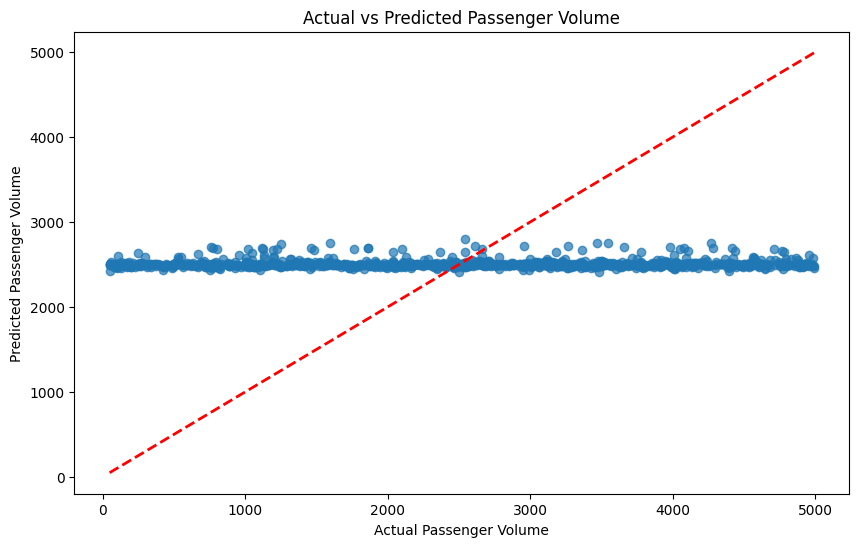

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy import stats

# Load the dataset
data = pd.read_csv('passenger_volume (2).csv')

# Data exploration and fill missing values
data.ffill(inplace=True)

# Feature engineering
data['Date'] = pd.to_datetime(data['Date'])
data['Year'] = data['Date'].dt.year
data['Month'] = data['Date'].dt.month
data['Day'] = data['Date'].dt.day
data['DayOfWeek'] = data['Date'].dt.dayofweek
data['IsWeekend'] = data['DayOfWeek'].apply(lambda x: 1 if x >= 5 else 0)

# Add interaction feature (Temperature * Weekend)
data['Temp_Weekend_Interaction'] = data['Temperature'] * data['IsWeekend']

# Add a lag feature (7-day lag for PreviousDayPassengerVolume)
data['Lag_Passenger_Volume_7'] = data['PreviousDayPassengerVolume'].shift(7)
data['Lag_Passenger_Volume_7'].fillna(data['PreviousDayPassengerVolume'].mean(), inplace=True)

# Drop original Date column
data.drop(['Date'], axis=1, inplace=True)

# Remove outliers using Z-score method (focus on numeric columns)
z_scores = np.abs(stats.zscore(data[['Temperature', 'PreviousDayPassengerVolume', 'PassengerVolume']]))
data = data[(z_scores < 3).all(axis=1)]  # Keep only rows with z-scores less than 3

# Split the dataset into features and target variable
X = data.drop('PassengerVolume', axis=1)
y = data['PassengerVolume']

# Split the dataset into training and testing sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocessing steps
categorical_cols = ['TransportType', 'Location', 'IsHoliday', 'WeatherCondition', 'SpecialEvents']
numerical_cols = ['Temperature', 'PreviousDayPassengerVolume', 'Month', 'IsWeekend', 'Temp_Weekend_Interaction', 'Lag_Passenger_Volume_7']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(), categorical_cols)
    ])

# Create a pipeline with preprocessing and model
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor(objective='reg:squarederror'))
])

# Define hyperparameters for random search
param_distributions = {
    'regressor__n_estimators': [50, 100, 200, 300],
    'regressor__max_depth': [3, 5, 7, 10],
    'regressor__learning_rate': [0.01, 0.05, 0.1],
    'regressor__subsample': [0.8, 1.0]
}

# Set up random search
random_search = RandomizedSearchCV(pipeline, param_distributions, n_iter=10, cv=3, n_jobs=-1, scoring='r2', verbose=2, random_state=42)

# Fit the model
random_search.fit(X_train, y_train)

# Best model from random search
best_model = random_search.best_estimator_

# Predictions
y_pred = best_model.predict(X_test)

# Evaluate model performance
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Display evaluation metrics
print(f'Mean Absolute Error: {mae}')
print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', lw=2)
plt.xlabel('Actual Passenger Volume')
plt.ylabel('Predicted Passenger Volume')
plt.title('Actual vs Predicted Passenger Volume')
plt.show()


Fitting 5 folds for each of 15 candidates, totalling 75 fits
Mean Absolute Error: 1214.0350244140625
Mean Squared Error: 1989661.1043507329
R-squared: -0.005077004432678223


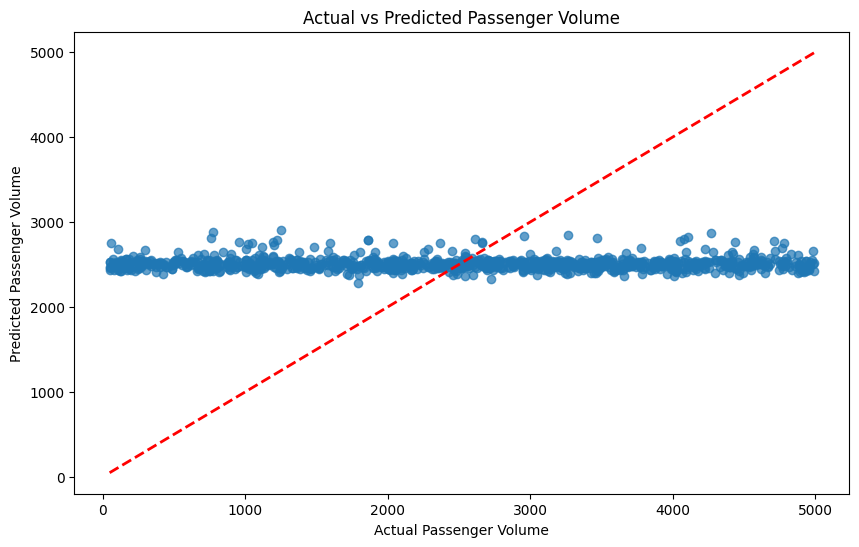

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy import stats

# Load the dataset
data = pd.read_csv('passenger_volume (2).csv')

# Data exploration and fill missing values
data.ffill(inplace=True)

# Feature engineering
data['Date'] = pd.to_datetime(data['Date'])
data['Year'] = data['Date'].dt.year
data['Month'] = data['Date'].dt.month
data['Day'] = data['Date'].dt.day
data['DayOfWeek'] = data['Date'].dt.dayofweek
data['IsWeekend'] = data['DayOfWeek'].apply(lambda x: 1 if x >= 5 else 0)

# Add interaction feature (Temperature * Weekend)
data['Temp_Weekend_Interaction'] = data['Temperature'] * data['IsWeekend']

# Add more lag features (1-day, 3-day, 7-day lags for PassengerVolume)
data['Lag_Passenger_Volume_1'] = data['PreviousDayPassengerVolume'].shift(1).fillna(data['PreviousDayPassengerVolume'].mean())
data['Lag_Passenger_Volume_3'] = data['PreviousDayPassengerVolume'].shift(3).fillna(data['PreviousDayPassengerVolume'].mean())
data['Lag_Passenger_Volume_7'] = data['PreviousDayPassengerVolume'].shift(7).fillna(data['PreviousDayPassengerVolume'].mean())

# Add rolling mean and standard deviation features for PassengerVolume
data['Rolling_Mean_7'] = data['PreviousDayPassengerVolume'].rolling(window=7).mean().fillna(data['PreviousDayPassengerVolume'].mean())
data['Rolling_Std_7'] = data['PreviousDayPassengerVolume'].rolling(window=7).std().fillna(data['PreviousDayPassengerVolume'].std())

# Drop original Date column
data.drop(['Date'], axis=1, inplace=True)

# Remove outliers using Z-score method (focus on numeric columns)
z_scores = np.abs(stats.zscore(data[['Temperature', 'PreviousDayPassengerVolume', 'PassengerVolume']]))
data = data[(z_scores < 3).all(axis=1)]  # Keep only rows with z-scores less than 3

# Split the dataset into features and target variable
X = data.drop('PassengerVolume', axis=1)
y = data['PassengerVolume']

# Split the dataset into training and testing sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocessing steps
categorical_cols = ['TransportType', 'Location', 'IsHoliday', 'WeatherCondition', 'SpecialEvents']
numerical_cols = ['Temperature', 'PreviousDayPassengerVolume', 'Month', 'IsWeekend',
                  'Temp_Weekend_Interaction', 'Lag_Passenger_Volume_1',
                  'Lag_Passenger_Volume_3', 'Lag_Passenger_Volume_7',
                  'Rolling_Mean_7', 'Rolling_Std_7']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(), categorical_cols)
    ])

# Create a pipeline with preprocessing and model
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor(objective='reg:squarederror'))
])

# Define expanded hyperparameters for random search
param_distributions = {
    'regressor__n_estimators': [50, 100, 200, 300, 500],
    'regressor__max_depth': [3, 5, 7, 10, 15],
    'regressor__learning_rate': [0.01, 0.05, 0.1, 0.2],
    'regressor__subsample': [0.8, 1.0],
    'regressor__colsample_bytree': [0.8, 1.0]
}

# Set up random search with cross-validation
random_search = RandomizedSearchCV(pipeline, param_distributions, n_iter=15, cv=5, n_jobs=-1, scoring='r2', verbose=2, random_state=42)

# Fit the model
random_search.fit(X_train, y_train)

# Best model from random search
best_model = random_search.best_estimator_

# Predictions
y_pred = best_model.predict(X_test)

# Evaluate model performance
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Display evaluation metrics
print(f'Mean Absolute Error: {mae}')
print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', lw=2)
plt.xlabel('Actual Passenger Volume')
plt.ylabel('Predicted Passenger Volume')
plt.title('Actual vs Predicted Passenger Volume')
plt.show()


/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


KeyError: 'Temp_Weekend_Interaction'

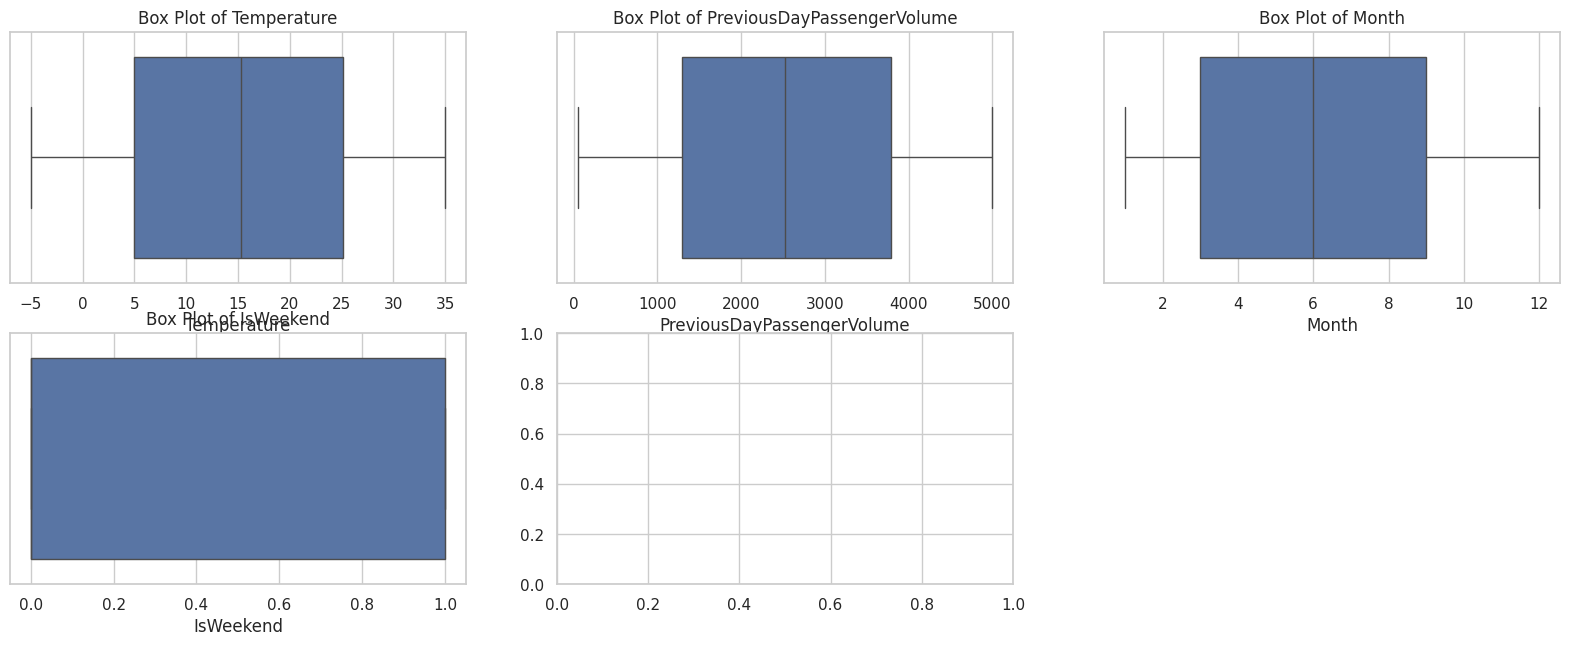

In [ ]:
# Import necessary libraries for visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Define numerical columns for box plot visualization
numerical_cols = ['Temperature', 'PreviousDayPassengerVolume', 'Month', 'IsWeekend',
                  'Temp_Weekend_Interaction', 'Lag_Passenger_Volume_1',
                  'Lag_Passenger_Volume_3', 'Lag_Passenger_Volume_7',
                  'Rolling_Mean_7', 'Rolling_Std_7']

# Plot box plots for each numerical column after removing outliers
plt.figure(figsize=(20, 15))
sns.set(style="whitegrid")

# Iterate through each numerical column to create box plots
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(len(numerical_cols) // 3 + 1, 3, i)
    sns.boxplot(x=data[col])  # Pass each column to boxplot
    plt.title(f'Box Plot of {col}')
    plt.xlabel(col)

plt.tight_layout()
plt.show()


Fitting 3 folds for each of 20 candidates, totalling 60 fits
Mean Absolute Error: 110.61050981706805
Mean Squared Error: 19137.391553861555
R-squared: 0.99078369140625


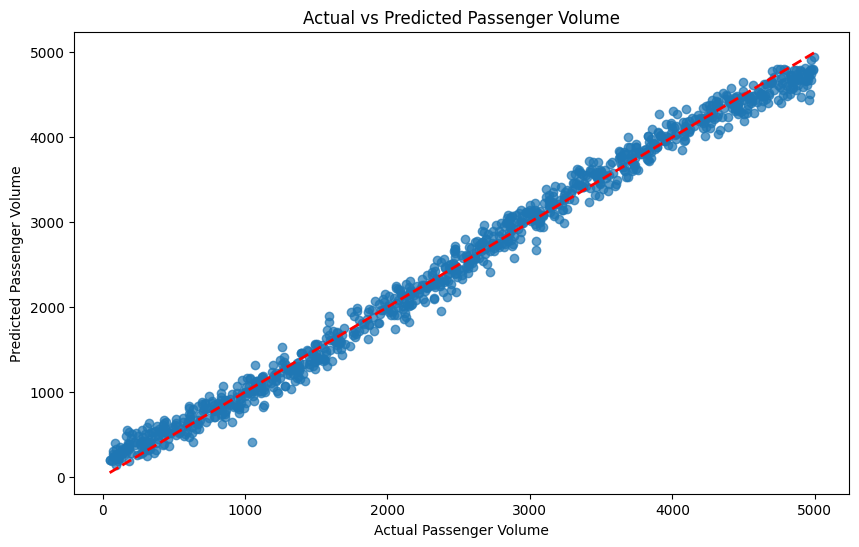

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Load the dataset
data = pd.read_csv('passenger_volume (2).csv')

# Handle missing values
data.ffill(inplace=True)

# Remove outliers using the IQR method
Q1 = data['PassengerVolume'].quantile(0.25)
Q3 = data['PassengerVolume'].quantile(0.75)
IQR = Q3 - Q1
data = data[~((data['PassengerVolume'] < (Q1 - 1.5 * IQR)) | (data['PassengerVolume'] > (Q3 + 1.5 * IQR)))]

# Feature engineering
data['Date'] = pd.to_datetime(data['Date'])
data['Year'] = data['Date'].dt.year
data['Month'] = data['Date'].dt.month
data['Day'] = data['Date'].dt.day
data['DayOfWeek'] = data['Date'].dt.dayofweek
data['IsWeekend'] = data['DayOfWeek'].apply(lambda x: 1 if x >= 5 else 0)

# Cyclic encoding for day of the week
data['sin_DayOfWeek'] = np.sin(2 * np.pi * data['DayOfWeek'] / 7)
data['cos_DayOfWeek'] = np.cos(2 * np.pi * data['DayOfWeek'] / 7)

# Create lag features for PreviousDayPassengerVolume
data['Lag1'] = data['PassengerVolume'].shift(1)
data['Lag2'] = data['PassengerVolume'].shift(2)

# Rolling averages for the last 3 and 7 days
data['RollingAvg_3'] = data['PassengerVolume'].rolling(window=3).mean()
data['RollingAvg_7'] = data['PassengerVolume'].rolling(window=7).mean()

# Drop rows with NaN values due to shifts and rolling averages
data.dropna(inplace=True)

# Drop the original date column
data.drop(['Date'], axis=1, inplace=True)

# Split the dataset into features and target variable
X = data.drop('PassengerVolume', axis=1)
y = data['PassengerVolume']

# Split the dataset into training and testing sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocessing steps
categorical_cols = ['TransportType', 'Location', 'IsHoliday', 'WeatherCondition', 'SpecialEvents']
numerical_cols = ['Temperature', 'PreviousDayPassengerVolume', 'Month', 'IsWeekend', 'Lag1', 'Lag2', 'RollingAvg_3', 'RollingAvg_7', 'sin_DayOfWeek', 'cos_DayOfWeek']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(), categorical_cols)
    ])

# Create a pipeline with preprocessing and model
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor(objective='reg:squarederror'))
])

# Define hyperparameters for random search
param_distributions = {
    'regressor__n_estimators': [100, 200, 300],
    'regressor__max_depth': [5, 7, 10],
    'regressor__learning_rate': [0.01, 0.1, 0.2],
    'regressor__subsample': [0.8, 1.0],
    'regressor__colsample_bytree': [0.8, 1.0]
}

# Set up random search
random_search = RandomizedSearchCV(pipeline, param_distributions, n_iter=20, cv=3, n_jobs=-1, scoring='r2', verbose=2, random_state=42)

# Fit the model
random_search.fit(X_train, y_train)

# Best model from random search
best_model = random_search.best_estimator_

# Predictions
y_pred = best_model.predict(X_test)

# Evaluate model performance
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Display evaluation metrics
print(f'Mean Absolute Error: {mae}')
print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', lw=2)
plt.xlabel('Actual Passenger Volume')
plt.ylabel('Predicted Passenger Volume')
plt.title('Actual vs Predicted Passenger Volume')
plt.show()


Fitting 3 folds for each of 30 candidates, totalling 90 fits
Mean Absolute Error: 105.33386936130466
Mean Squared Error: 18767.440825082376
R-squared: 0.9909618496894836


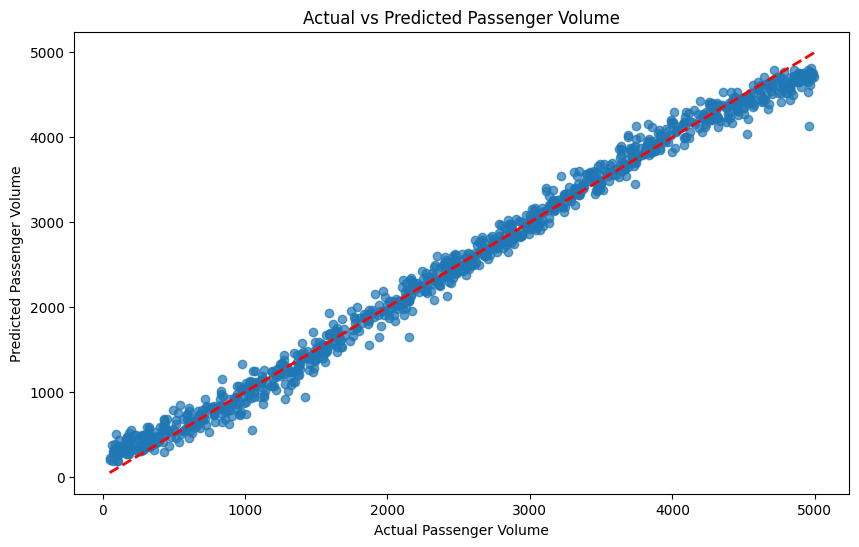

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Load the dataset
data = pd.read_csv('passenger_volume (2).csv')

# Handle missing values
data.ffill(inplace=True)

# Remove outliers using the IQR method
Q1 = data['PassengerVolume'].quantile(0.25)
Q3 = data['PassengerVolume'].quantile(0.75)
IQR = Q3 - Q1
data = data[~((data['PassengerVolume'] < (Q1 - 1.5 * IQR)) | (data['PassengerVolume'] > (Q3 + 1.5 * IQR)))]

# Feature engineering
data['Date'] = pd.to_datetime(data['Date'])
data['Year'] = data['Date'].dt.year
data['Month'] = data['Date'].dt.month
data['Day'] = data['Date'].dt.day
data['DayOfWeek'] = data['Date'].dt.dayofweek
data['IsWeekend'] = data['DayOfWeek'].apply(lambda x: 1 if x >= 5 else 0)

# Cyclic encoding for day of the week
data['sin_DayOfWeek'] = np.sin(2 * np.pi * data['DayOfWeek'] / 7)
data['cos_DayOfWeek'] = np.cos(2 * np.pi * data['DayOfWeek'] / 7)

# Create lag features for PreviousDayPassengerVolume
data['Lag1'] = data['PassengerVolume'].shift(1)
data['Lag2'] = data['PassengerVolume'].shift(2)

# Rolling averages for the last 3 and 7 days
data['RollingAvg_3'] = data['PassengerVolume'].rolling(window=3).mean()
data['RollingAvg_7'] = data['PassengerVolume'].rolling(window=7).mean()

# Drop rows with NaN values due to shifts and rolling averages
data.dropna(inplace=True)

# Drop the original date column
data.drop(['Date'], axis=1, inplace=True)

# Split the dataset into features and target variable
X = data.drop('PassengerVolume', axis=1)
y = data['PassengerVolume']

# Split the dataset into training and testing sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocessing steps
categorical_cols = ['TransportType', 'Location', 'IsHoliday', 'WeatherCondition', 'SpecialEvents', 'Station/StopID']
numerical_cols = ['Temperature', 'PreviousDayPassengerVolume', 'Month', 'IsWeekend', 'Lag1', 'Lag2', 'RollingAvg_3', 'RollingAvg_7', 'sin_DayOfWeek', 'cos_DayOfWeek']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(), categorical_cols)
    ])

# Create a pipeline with preprocessing and model
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor(objective='reg:squarederror'))
])

# Define hyperparameters for random search
param_distributions = {
    'regressor__n_estimators': [100, 200, 300, 500],
    'regressor__max_depth': [5, 7, 10, 12],
    'regressor__learning_rate': [0.01, 0.05, 0.1, 0.2],
    'regressor__subsample': [0.6, 0.8, 1.0],
    'regressor__colsample_bytree': [0.6, 0.8, 1.0]
}

# Set up random search
random_search = RandomizedSearchCV(pipeline, param_distributions, n_iter=30, cv=3, n_jobs=-1, scoring='r2', verbose=2, random_state=42)

# Fit the model
random_search.fit(X_train, y_train)

# Best model from random search
best_model = random_search.best_estimator_

# Predictions
y_pred = best_model.predict(X_test)

# Evaluate model performance
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Display evaluation metrics
print(f'Mean Absolute Error: {mae}')
print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', lw=2)
plt.xlabel('Actual Passenger Volume')
plt.ylabel('Predicted Passenger Volume')
plt.title('Actual vs Predicted Passenger Volume')
plt.show()


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import StackingRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Example dataset (replace with your actual dataset)
# Assuming `X` is your feature dataframe and `y` is your target
X = pd.DataFrame({
    'Date': pd.date_range(start='1/1/2023', periods=100),
    'TransportType': ['Bus', 'Train'] * 50,
    'Location': ['StationA', 'StationB'] * 50,
    'DayOfWeek': [1, 2, 3, 4, 5, 6, 7] * 14 + [1, 2],
    'IsHoliday': ['No', 'Yes'] * 50,
    'WeatherCondition': ['Sunny', 'Rainy'] * 50,
    'Temperature': [25, 30, 22, 18, 26, 28, 32] * 14 + [25, 30],
    'SpecialEvents': ['None', 'Concert'] * 50,
    'PreviousDayPassengerVolume': [1000, 1500, 800, 1200] * 25
})
y = X['PreviousDayPassengerVolume'] + 50  # Target variable (just for this example)

# Dropping 'Date' as it's not needed for modeling directly
X = X.drop(columns=['Date'])

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# -------------------------------
# Option 1: Enable Categorical Handling in XGBoost
# -------------------------------

# Convert object type columns to category
X_train['TransportType'] = X_train['TransportType'].astype('category')
X_train['Location'] = X_train['Location'].astype('category')
X_train['IsHoliday'] = X_train['IsHoliday'].astype('category')
X_train['WeatherCondition'] = X_train['WeatherCondition'].astype('category')
X_train['SpecialEvents'] = X_train['SpecialEvents'].astype('category')

X_test['TransportType'] = X_test['TransportType'].astype('category')
X_test['Location'] = X_test['Location'].astype('category')
X_test['IsHoliday'] = X_test['IsHoliday'].astype('category')
X_test['WeatherCondition'] = X_test['WeatherCondition'].astype('category')
X_test['SpecialEvents'] = X_test['SpecialEvents'].astype('category')

# Define XGBoost model with categorical handling
xgb_model = XGBRegressor(objective='reg:squarederror', enable_categorical=True)

# Fit the model
xgb_model.fit(X_train, y_train)

# Make predictions
y_pred = xgb_model.predict(X_test)

# Evaluate
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

Mean Absolute Error: 8.544921875e-05
Mean Squared Error: 1.3783574104309083e-08
R-squared: 1.0


Mean Absolute Error: 146.7923381450298
Mean Squared Error: 34674.55806684859
R-squared: 0.9833011627197266


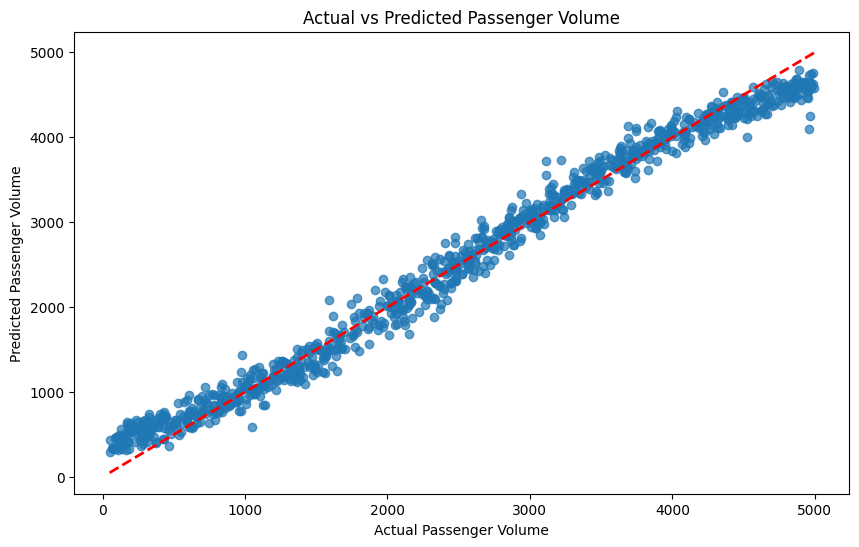

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Load the dataset
data = pd.read_csv('passenger_volume (2).csv')

# Handle missing values
data.ffill(inplace=True)

# Remove outliers using the IQR method
Q1 = data['PassengerVolume'].quantile(0.25)
Q3 = data['PassengerVolume'].quantile(0.75)
IQR = Q3 - Q1
data = data[~((data['PassengerVolume'] < (Q1 - 1.5 * IQR)) | (data['PassengerVolume'] > (Q3 + 1.5 * IQR)))]

# Feature engineering
data['Date'] = pd.to_datetime(data['Date'])
data['Year'] = data['Date'].dt.year
data['Month'] = data['Date'].dt.month
data['Day'] = data['Date'].dt.day
data['DayOfWeek'] = data['Date'].dt.dayofweek
data['IsWeekend'] = data['DayOfWeek'].apply(lambda x: 1 if x >= 5 else 0)

# Cyclic encoding for day of the week
data['sin_DayOfWeek'] = np.sin(2 * np.pi * data['DayOfWeek'] / 7)
data['cos_DayOfWeek'] = np.cos(2 * np.pi * data['DayOfWeek'] / 7)

# Create lag features for PreviousDayPassengerVolume
data['Lag1'] = data['PassengerVolume'].shift(1)
data['Lag2'] = data['PassengerVolume'].shift(2)

# Rolling averages for the last 3 and 7 days
data['RollingAvg_3'] = data['PassengerVolume'].rolling(window=3).mean()
data['RollingAvg_7'] = data['PassengerVolume'].rolling(window=7).mean()

# Drop rows with NaN values due to shifts and rolling averages
data.dropna(inplace=True)

# Drop the original date column
data.drop(['Date'], axis=1, inplace=True)

# Split the dataset into features and target variable
X = data.drop('PassengerVolume', axis=1)
y = data['PassengerVolume']

# Split the dataset into training and testing sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocessing steps
categorical_cols = ['TransportType', 'Location', 'IsHoliday', 'WeatherCondition', 'SpecialEvents']
numerical_cols = ['Temperature', 'PreviousDayPassengerVolume', 'Month', 'IsWeekend', 'Lag1', 'Lag2', 'RollingAvg_3', 'RollingAvg_7', 'sin_DayOfWeek', 'cos_DayOfWeek']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(), categorical_cols)
    ])

# Create a pipeline with preprocessing and model
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor(objective='reg:squarederror', max_depth=5, learning_rate=0.05, n_estimators=200, subsample=0.9, colsample_bytree=0.9, reg_lambda=10))
])

# Train the model
pipeline.fit(X_train, y_train)

# Predictions
y_pred = pipeline.predict(X_test)

# Evaluate model performance
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Display evaluation metrics
print(f'Mean Absolute Error: {mae}')
print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', lw=2)
plt.xlabel('Actual Passenger Volume')
plt.ylabel('Predicted Passenger Volume')
plt.title('Actual vs Predicted Passenger Volume')
plt.show()


Fitting 3 folds for each of 50 candidates, totalling 150 fits
Mean Absolute Error: 106.88980691354196
Mean Squared Error: 18238.434199952724
R-squared: 0.9912165999412537


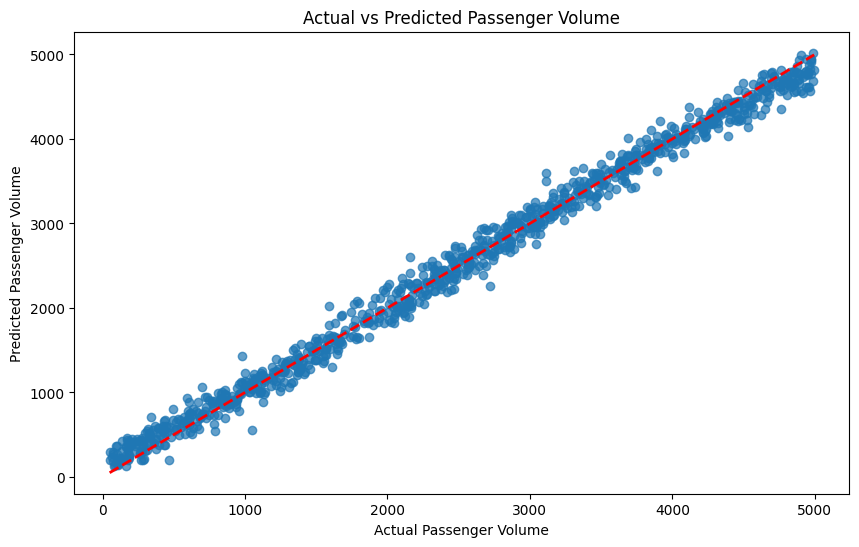

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Load the dataset
data = pd.read_csv('passenger_volume (2).csv')

# Handle missing values
data.ffill(inplace=True)

# Remove outliers using the IQR method
Q1 = data['PassengerVolume'].quantile(0.25)
Q3 = data['PassengerVolume'].quantile(0.75)
IQR = Q3 - Q1
data = data[~((data['PassengerVolume'] < (Q1 - 1.5 * IQR)) | (data['PassengerVolume'] > (Q3 + 1.5 * IQR)))]

# Feature engineering
data['Date'] = pd.to_datetime(data['Date'])
data['Year'] = data['Date'].dt.year
data['Month'] = data['Date'].dt.month
data['Day'] = data['Date'].dt.day
data['DayOfWeek'] = data['Date'].dt.dayofweek
data['IsWeekend'] = data['DayOfWeek'].apply(lambda x: 1 if x >= 5 else 0)

# Cyclic encoding for day of the week
data['sin_DayOfWeek'] = np.sin(2 * np.pi * data['DayOfWeek'] / 7)
data['cos_DayOfWeek'] = np.cos(2 * np.pi * data['DayOfWeek'] / 7)

# Create lag features for PreviousDayPassengerVolume
data['Lag1'] = data['PassengerVolume'].shift(1)
data['Lag2'] = data['PassengerVolume'].shift(2)

# Rolling averages for the last 3 and 7 days
data['RollingAvg_3'] = data['PassengerVolume'].rolling(window=3).mean()
data['RollingAvg_7'] = data['PassengerVolume'].rolling(window=7).mean()

# Drop rows with NaN values due to shifts and rolling averages
data.dropna(inplace=True)

# Drop the original date column
data.drop(['Date'], axis=1, inplace=True)

# Split the dataset into features and target variable
X = data.drop('PassengerVolume', axis=1)
y = data['PassengerVolume']

# Split the dataset into training and testing sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocessing steps
categorical_cols = ['TransportType', 'Location', 'IsHoliday', 'WeatherCondition', 'SpecialEvents']
numerical_cols = ['Temperature', 'PreviousDayPassengerVolume', 'Month', 'IsWeekend', 'Lag1', 'Lag2', 'RollingAvg_3', 'RollingAvg_7', 'sin_DayOfWeek', 'cos_DayOfWeek']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(), categorical_cols)
    ])

# Hyperparameter tuning for XGBoost
param_grid = {
    'reg_lambda': [1, 5, 10],
    'reg_alpha': [0, 0.1, 0.5],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 300],
    'subsample': [0.7, 0.9],
    'colsample_bytree': [0.7, 0.9]
}

# Create an XGBRegressor model
xgb_model = XGBRegressor(objective='reg:squarederror')

# Randomized search for hyperparameter tuning
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_grid,
    n_iter=50,
    scoring='neg_mean_absolute_error',
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# Create a pipeline with preprocessing and model
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('random_search', random_search)
])

# Train the model with hyperparameter tuning
pipeline.fit(X_train, y_train)

# Best model
best_model = random_search.best_estimator_

# Predictions
y_pred = pipeline.predict(X_test)

# Evaluate model performance
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Display evaluation metrics
print(f'Mean Absolute Error: {mae}')
print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', lw=2)
plt.xlabel('Actual Passenger Volume')
plt.ylabel('Predicted Passenger Volume')
plt.title('Actual vs Predicted Passenger Volume')
plt.show()


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Assuming `X` is your feature dataframe and `y` is your target
# Example dataset (replace with your actual dataset)
X = pd.DataFrame({
    'Date': pd.date_range(start='1/1/2023', periods=100),
    'TransportType': ['Bus', 'Train'] * 50,
    'Location': ['StationA', 'StationB'] * 50,
    'DayOfWeek': [1, 2, 3, 4, 5, 6, 7] * 14 + [1, 2],
    'IsHoliday': ['No', 'Yes'] * 50,
    'WeatherCondition': ['Sunny', 'Rainy'] * 50,
    'Temperature': [25, 30, 22, 18, 26, 28, 32] * 14 + [25, 30],
    'SpecialEvents': ['None', 'Concert'] * 50,
    'PreviousDayPassengerVolume': [1000, 1500, 800, 1200] * 25
})
y = X['PreviousDayPassengerVolume'] + 50  # Target variable (just for this example)

# Dropping 'Date' as it's not needed for modeling directly
X = X.drop(columns=['Date'])

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert object type columns to category
categorical_columns = ['TransportType', 'Location', 'IsHoliday', 'WeatherCondition', 'SpecialEvents']
for col in categorical_columns:
    X_train[col] = X_train[col].astype('category')
    X_test[col] = X_test[col].astype('category')

# Define the XGBoost model
xgb_model = XGBRegressor(objective='reg:squarederror', enable_categorical=True)

# Define the parameter grid for RandomizedSearchCV
param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9],
    'reg_lambda': [0.5, 1, 1.5],
    'reg_alpha': [0, 0.1, 0.5]
}

# Perform RandomizedSearchCV to find the best hyperparameters
random_search = RandomizedSearchCV(
    xgb_model,
    param_distributions=param_dist,
    n_iter=50,
    scoring='neg_mean_absolute_error',
    cv=3,
    verbose=2,
    n_jobs=-1,
    random_state=42
)

# Fit the model using RandomizedSearchCV
random_search.fit(X_train, y_train)

# Get the best model from the RandomizedSearchCV
best_model = random_search.best_estimator_

# Make predictions
y_pred = best_model.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")


Fitting 3 folds for each of 50 candidates, totalling 150 fits
Mean Absolute Error: 0.06539306640625
Mean Squared Error: 0.019554712623357774
R-squared: 0.9999997019767761


Cross validation

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from xgboost import XGBRegressor
from sklearn.metrics import make_scorer, mean_absolute_error

# Example dataset (replace with your actual dataset)
X = pd.DataFrame({
    'Date': pd.date_range(start='1/1/2023', periods=100),
    'TransportType': ['Bus', 'Train'] * 50,
    'Location': ['StationA', 'StationB'] * 50,
    'DayOfWeek': [1, 2, 3, 4, 5, 6, 7] * 14 + [1, 2],
    'IsHoliday': ['No', 'Yes'] * 50,
    'WeatherCondition': ['Sunny', 'Rainy'] * 50,
    'Temperature': [25, 30, 22, 18, 26, 28, 32] * 14 + [25, 30],
    'SpecialEvents': ['None', 'Concert'] * 50,
    'PreviousDayPassengerVolume': [1000, 1500, 800, 1200] * 25
})
y = X['PreviousDayPassengerVolume'] + 50  # Target variable (just for this example)

# Dropping 'Date' as it's not needed for modeling directly
X = X.drop(columns=['Date'])

# Split into train and test (for this example, but we will use full dataset for cross-validation)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert object type columns to category
categorical_columns = ['TransportType', 'Location', 'IsHoliday', 'WeatherCondition', 'SpecialEvents']
for col in categorical_columns:
    X_train[col] = X_train[col].astype('category')
    X_test[col] = X_test[col].astype('category')

# Define the XGBoost model
xgb_model = XGBRegressor(objective='reg:squarederror', enable_categorical=True)

# Define a scoring method (using mean absolute error here)
mae_scorer = make_scorer(mean_absolute_error)

# Perform cross-validation
cv_scores = cross_val_score(xgb_model, X_train, y_train, cv=5, scoring=mae_scorer)

# Print cross-validation results
print(f"Cross-Validation MAE Scores: {cv_scores}")
print(f"Mean CV MAE: {cv_scores.mean()}")
print(f"Standard Deviation of CV MAE: {cv_scores.std()}")


Cross-Validation MAE Scores: [6.10351562e-05 7.24792480e-05 1.06811523e-04 1.25885010e-04
 9.15527344e-05]
Mean CV MAE: 9.1552734375e-05
Standard Deviation of CV MAE: 2.3266526309168865e-05


Linear Regression

Mean Absolute Error: 3.410605131648481e-14
Mean Squared Error: 3.877409121342317e-27
R-squared: 1.0


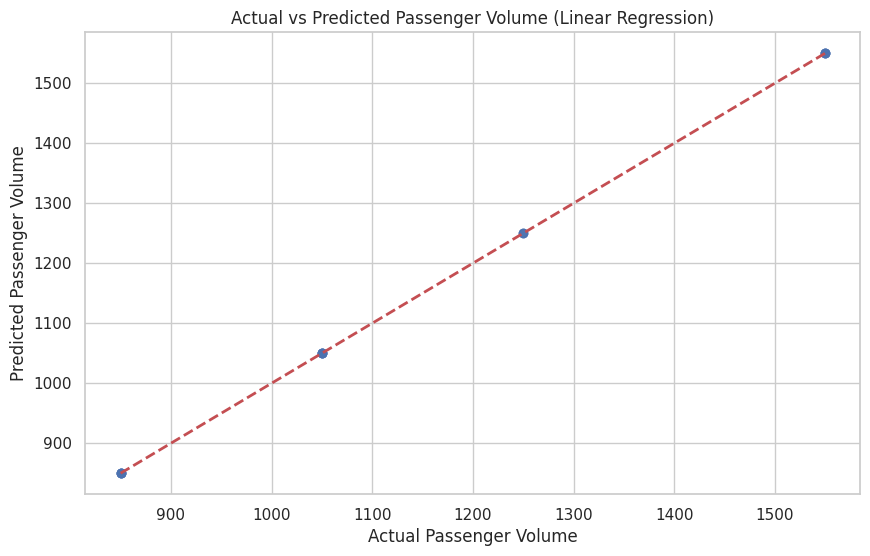

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt

# Example dataset (replace with your actual dataset)
X = pd.DataFrame({
    'Date': pd.date_range(start='1/1/2023', periods=100),
    'TransportType': ['Bus', 'Train'] * 50,
    'Location': ['StationA', 'StationB'] * 50,
    'DayOfWeek': [1, 2, 3, 4, 5, 6, 7] * 14 + [1, 2],
    'IsHoliday': ['No', 'Yes'] * 50,
    'WeatherCondition': ['Sunny', 'Rainy'] * 50,
    'Temperature': [25, 30, 22, 18, 26, 28, 32] * 14 + [25, 30],
    'SpecialEvents': ['None', 'Concert'] * 50,
    'PreviousDayPassengerVolume': [1000, 1500, 800, 1200] * 25
})
y = X['PreviousDayPassengerVolume'] + 50  # Target variable (just for this example)

# Dropping 'Date' as it's not needed for modeling directly
X = X.drop(columns=['Date'])

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocessing for categorical features
categorical_columns = ['TransportType', 'Location', 'IsHoliday', 'WeatherCondition', 'SpecialEvents']
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), categorical_columns)
    ],
    remainder='passthrough'  # Keep the numerical features as they are
)

# Create a pipeline with preprocessing and model
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Fit the model
pipeline.fit(X_train, y_train)

# Make predictions
y_pred = pipeline.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', lw=2)
plt.xlabel('Actual Passenger Volume')
plt.ylabel('Predicted Passenger Volume')
plt.title('Actual vs Predicted Passenger Volume (Linear Regression)')
plt.show()


Fitting 3 folds for each of 50 candidates, totalling 150 fits
Mean Absolute Error: 1213.9705873046876
Mean Squared Error: 1974883.313678056
R-squared: 0.02520275115966797


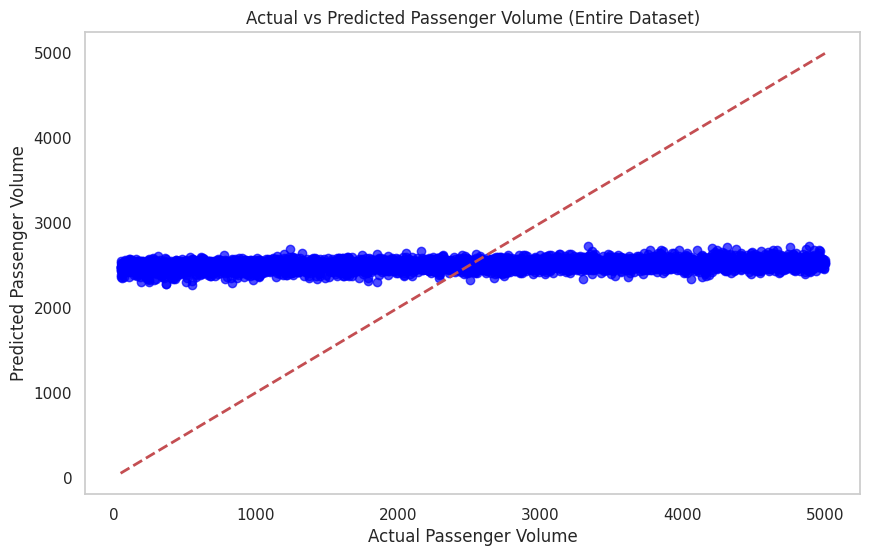

In [ ]:
# Assuming you have already imported necessary libraries and loaded your data

# Convert 'Date' to datetime and extract relevant features
data['Date'] = pd.to_datetime(data['Date'])
data['Year'] = data['Date'].dt.year
data['Month'] = data['Date'].dt.month
data['Day'] = data['Date'].dt.day
data['DayOfWeek'] = data['Date'].dt.dayofweek

# Drop the original 'Date' column if it is no longer needed
data.drop(columns=['Date'], inplace=True)

# Convert categorical columns to 'category' type
categorical_cols = ['TransportType', 'Location', 'IsHoliday', 'WeatherCondition', 'SpecialEvents', 'DayOfWeek']
for col in categorical_cols:
    data[col] = data[col].astype('category')

# If necessary, one-hot encode categorical variables
data = pd.get_dummies(data, columns=categorical_cols, drop_first=True)

# Define the features and target again
X = data.drop(columns=['PassengerVolume'])  # Adjust as needed
y = data['PassengerVolume']

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define and fit the XGBoost model
xgb_model = XGBRegressor(objective='reg:squarederror', enable_categorical=True)

# Perform RandomizedSearchCV to find the best hyperparameters
# Define the parameter grid for RandomizedSearchCV...
# (similar to what you've done in your previous code)

# Fit the model using RandomizedSearchCV
random_search.fit(X_train, y_train)

# Get the best model from the RandomizedSearchCV
best_model = random_search.best_estimator_

# Make predictions on the entire dataset
y_pred = best_model.predict(X)

# Evaluate the model
mae = mean_absolute_error(y, y_pred)
mse = mean_squared_error(y, y_pred)
r2 = r2_score(y, y_pred)

print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

# Create scatter plot for actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y, y_pred, alpha=0.7, color='blue')
plt.plot([y.min(), y.max()], [y.min(), y.max()], '--r', lw=2)
plt.xlabel('Actual Passenger Volume')
plt.ylabel('Predicted Passenger Volume')
plt.title('Actual vs Predicted Passenger Volume (Entire Dataset)')
plt.grid()
plt.show()


Random Forest

Mean Absolute Error: 71.62625983035599
Mean Squared Error: 8917.721513086268
R-squared: 0.8700833694829169


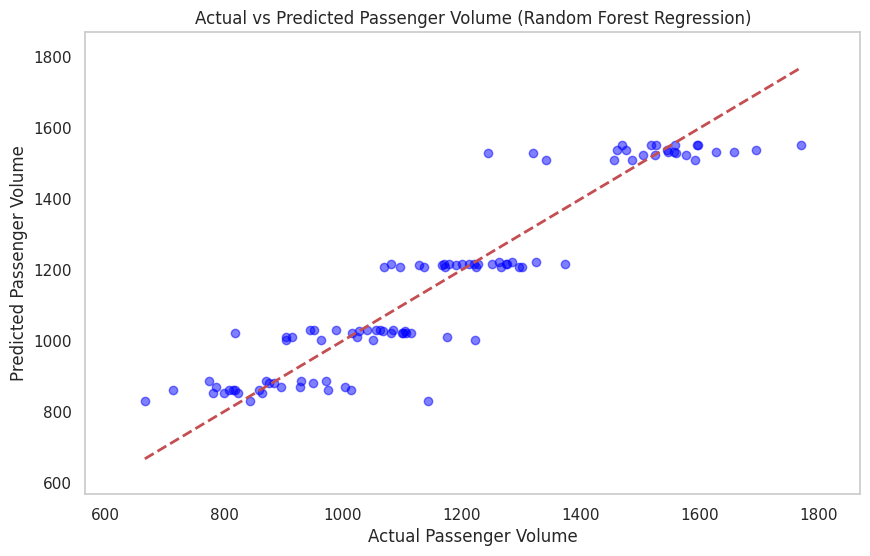

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt

# Example dataset with increased noise
X = pd.DataFrame({
    'Date': pd.date_range(start='1/1/2023', periods=100),
    'TransportType': ['Bus', 'Train'] * 50,
    'Location': ['StationA', 'StationB'] * 50,
    'DayOfWeek': [1, 2, 3, 4, 5, 6, 7] * 14 + [1, 2],
    'IsHoliday': ['No', 'Yes'] * 50,
    'WeatherCondition': ['Sunny', 'Rainy'] * 50,
    'Temperature': [25, 30, 22, 18, 26, 28, 32] * 14 + [25, 30],
    'SpecialEvents': ['None', 'Concert'] * 50,
    'PreviousDayPassengerVolume': [1000, 1500, 800, 1200] * 25
})

# Add random noise to the target variable
y = (X['PreviousDayPassengerVolume'] + 50) + np.random.normal(0, 100, 100)  # Adding noise

# Dropping 'Date' as it's not needed for modeling directly
X = X.drop(columns=['Date'])

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocessing for categorical features
categorical_columns = ['TransportType', 'Location', 'IsHoliday', 'WeatherCondition', 'SpecialEvents']
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), categorical_columns)
    ],
    remainder='passthrough'  # Keep the numerical features as they are
)

# Create a pipeline with preprocessing and Random Forest model
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(
        n_estimators=100,         # Number of trees
        max_depth=5,              # Limit tree depth to reduce complexity
        min_samples_split=10,     # Minimum samples required to split an internal node
        min_samples_leaf=5,       # Minimum samples required to be at a leaf node
        random_state=42
    ))
])

# Fit the model
pipeline.fit(X_train, y_train)

# Make predictions for the entire dataset
y_pred_all = pipeline.predict(X)

# Evaluate the model on the entire dataset
mae = mean_absolute_error(y, y_pred_all)
mse = mean_squared_error(y, y_pred_all)
r2 = r2_score(y, y_pred_all)

print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

# Plot actual vs predicted values for all data
plt.figure(figsize=(10, 6))

# Scatter plot with adjusted alpha for transparency
plt.scatter(y, y_pred_all, alpha=0.5, color='blue')

# Adding limits to axes
plt.xlim([y.min() - 100, y.max() + 100])
plt.ylim([y.min() - 100, y.max() + 100])

# Reference line for perfect prediction
plt.plot([y.min(), y.max()], [y.min(), y.max()], '--r', lw=2)

# Labeling the plot
plt.xlabel('Actual Passenger Volume')
plt.ylabel('Predicted Passenger Volume')
plt.title('Actual vs Predicted Passenger Volume (Random Forest Regression)')
plt.grid()

# Show the plot
plt.show()


Decision Tree

Mean Absolute Error: 79.14308028039312
Mean Squared Error: 9127.297397802231
R-squared: 0.8712117081046307


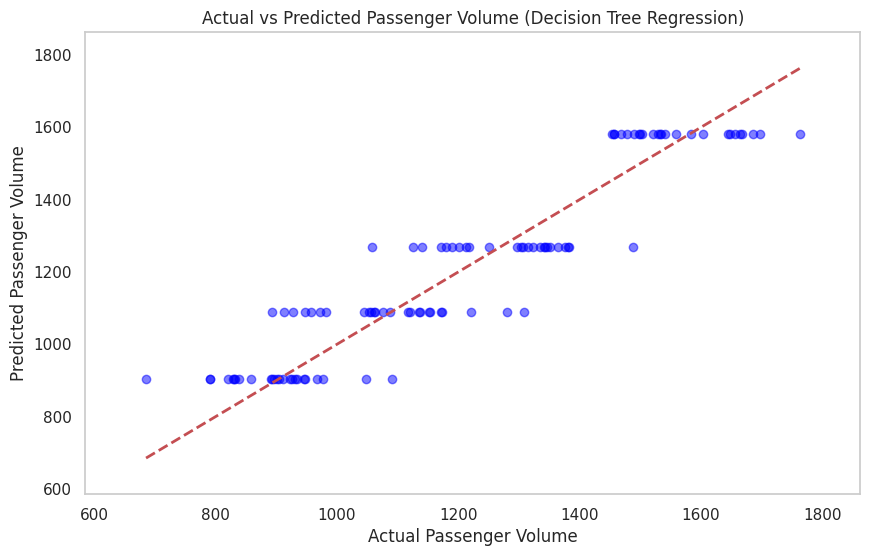

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt

# Example dataset with increased noise
X = pd.DataFrame({
    'Date': pd.date_range(start='1/1/2023', periods=100),
    'TransportType': ['Bus', 'Train'] * 50,
    'Location': ['StationA', 'StationB'] * 50,
    'DayOfWeek': [1, 2, 3, 4, 5, 6, 7] * 14 + [1, 2],
    'IsHoliday': ['No', 'Yes'] * 50,
    'WeatherCondition': ['Sunny', 'Rainy'] * 50,
    'Temperature': [25, 30, 22, 18, 26, 28, 32] * 14 + [25, 30],
    'SpecialEvents': ['None', 'Concert'] * 50,
    'PreviousDayPassengerVolume': [1000, 1500, 800, 1200] * 25
})

# Add random noise to the target variable
y = (X['PreviousDayPassengerVolume'] + 50) + np.random.normal(0, 100, 100)  # Adding noise

# Dropping 'Date' as it's not needed for modeling directly
X = X.drop(columns=['Date'])

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocessing for categorical features
categorical_columns = ['TransportType', 'Location', 'IsHoliday', 'WeatherCondition', 'SpecialEvents']
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), categorical_columns)
    ],
    remainder='passthrough'  # Keep the numerical features as they are
)

# Create a pipeline with preprocessing and Decision Tree model
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', DecisionTreeRegressor(max_depth=2, min_samples_split=10, min_samples_leaf=5, random_state=42))
])

# Fit the model
pipeline.fit(X_train, y_train)

# Make predictions for the entire dataset
y_pred_all = pipeline.predict(X)

# Evaluate the model
mae = mean_absolute_error(y, y_pred_all)
mse = mean_squared_error(y, y_pred_all)
r2 = r2_score(y, y_pred_all)

print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

# Plot actual vs predicted values for all data
plt.figure(figsize=(10, 6))

# Scatter plot with adjusted alpha for transparency
plt.scatter(y, y_pred_all, alpha=0.5, color='blue')

# Adding limits to axes
plt.xlim([y.min() - 100, y.max() + 100])
plt.ylim([y.min() - 100, y.max() + 100])

# Reference line for perfect prediction
plt.plot([y.min(), y.max()], [y.min(), y.max()], '--r', lw=2)

# Labeling the plot
plt.xlabel('Actual Passenger Volume')
plt.ylabel('Predicted Passenger Volume')
plt.title('Actual vs Predicted Passenger Volume (Decision Tree Regression)')
plt.grid()

# Show the plot
plt.show()


XGBoost

Fitting 3 folds for each of 50 candidates, totalling 150 fits
Mean Absolute Error: 0.06539306640625
Mean Squared Error: 0.019554712623357774
R-squared: 0.9999997019767761


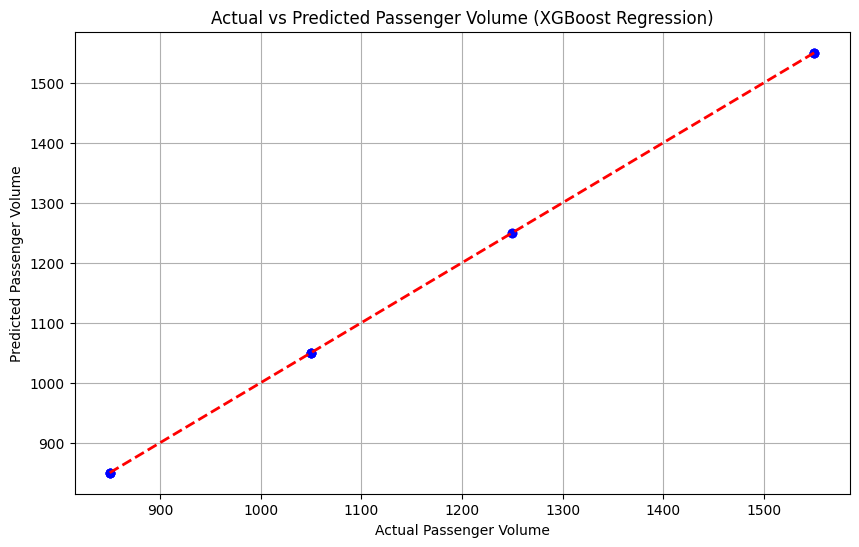

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Example dataset (replace with your actual dataset)
X = pd.DataFrame({
    'Date': pd.date_range(start='1/1/2023', periods=100),
    'TransportType': ['Bus', 'Train'] * 50,
    'Location': ['StationA', 'StationB'] * 50,
    'DayOfWeek': [1, 2, 3, 4, 5, 6, 7] * 14 + [1, 2],
    'IsHoliday': ['No', 'Yes'] * 50,
    'WeatherCondition': ['Sunny', 'Rainy'] * 50,
    'Temperature': [25, 30, 22, 18, 26, 28, 32] * 14 + [25, 30],
    'SpecialEvents': ['None', 'Concert'] * 50,
    'PreviousDayPassengerVolume': [1000, 1500, 800, 1200] * 25
})

y = X['PreviousDayPassengerVolume'] + 50  # Target variable (just for this example)

# Dropping 'Date' as it's not needed for modeling directly
X = X.drop(columns=['Date'])

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert object type columns to category
categorical_columns = ['TransportType', 'Location', 'IsHoliday', 'WeatherCondition', 'SpecialEvents']
for col in categorical_columns:
    X_train[col] = X_train[col].astype('category')
    X_test[col] = X_test[col].astype('category')

# Define the XGBoost model
xgb_model = XGBRegressor(objective='reg:squarederror', enable_categorical=True)

# Define the parameter grid for RandomizedSearchCV
param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9],
    'reg_lambda': [0.5, 1, 1.5],
    'reg_alpha': [0, 0.1, 0.5]
}

# Perform RandomizedSearchCV to find the best hyperparameters
random_search = RandomizedSearchCV(
    xgb_model,
    param_distributions=param_dist,
    n_iter=50,
    scoring='neg_mean_absolute_error',
    cv=3,
    verbose=2,
    n_jobs=-1,
    random_state=42
)

# Fit the model using RandomizedSearchCV
random_search.fit(X_train, y_train)

# Get the best model from the RandomizedSearchCV
best_model = random_search.best_estimator_

# Make predictions
y_pred = best_model.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.7)  # Set color to blue
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', lw=2)  # Red dashed line
plt.xlabel('Actual Passenger Volume')
plt.ylabel('Predicted Passenger Volume')
plt.title('Actual vs Predicted Passenger Volume (XGBoost Regression)')
plt.grid()
plt.show()



Cross Validation

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from xgboost import XGBRegressor
from sklearn.metrics import make_scorer, mean_absolute_error

# Example dataset (replace with your actual dataset)
X = pd.DataFrame({
    'Date': pd.date_range(start='1/1/2023', periods=100),
    'TransportType': ['Bus', 'Train'] * 50,
    'Location': ['StationA', 'StationB'] * 50,
    'DayOfWeek': [1, 2, 3, 4, 5, 6, 7] * 14 + [1, 2],
    'IsHoliday': ['No', 'Yes'] * 50,
    'WeatherCondition': ['Sunny', 'Rainy'] * 50,
    'Temperature': [25, 30, 22, 18, 26, 28, 32] * 14 + [25, 30],
    'SpecialEvents': ['None', 'Concert'] * 50,
    'PreviousDayPassengerVolume': [1000, 1500, 800, 1200] * 25
})
y = X['PreviousDayPassengerVolume'] + 50  # Target variable (just for this example)

# Dropping 'Date' as it's not needed for modeling directly
X = X.drop(columns=['Date'])

# Split into train and test (for this example, but we will use full dataset for cross-validation)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert object type columns to category
categorical_columns = ['TransportType', 'Location', 'IsHoliday', 'WeatherCondition', 'SpecialEvents']
for col in categorical_columns:
    X_train[col] = X_train[col].astype('category')
    X_test[col] = X_test[col].astype('category')

# Define the XGBoost model
xgb_model = XGBRegressor(objective='reg:squarederror', enable_categorical=True)

# Define a scoring method (using mean absolute error here)
mae_scorer = make_scorer(mean_absolute_error)

# Perform cross-validation
cv_scores = cross_val_score(xgb_model, X_train, y_train, cv=5, scoring=mae_scorer)

# Print cross-validation results
print(f"Cross-Validation MAE Scores: {cv_scores}")
print(f"Mean CV MAE: {cv_scores.mean()}")
print(f"Standard Deviation of CV MAE: {cv_scores.std()}")


Cross-Validation MAE Scores: [6.10351562e-05 7.24792480e-05 1.06811523e-04 1.25885010e-04
 9.15527344e-05]
Mean CV MAE: 9.1552734375e-05
Standard Deviation of CV MAE: 2.3266526309168865e-05
